In [16]:
from transformers import pipeline
import numpy as np
import pandas as pd
from sklearn import metrics
import torch
from datasets import Dataset
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB # https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes
from matplotlib import pyplot as plt

In [13]:
chex_df = pd.read_csv('/root/Project-CS224N-ED-Disposition/CheXbert-Labeler/labeled_reports_output.csv')
chex_df.head()

,Report Impression,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,1. Interval increase in perihilar opacities a...,NaN,NaN,1.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1. No acute intracranial abnormality. 2. Mil...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,1. Multiple loops of dilated small bowel with...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,1. Interval increased loculated moderate meta...,NaN,NaN,NaN,NaN,NaN,1.0,-1.0,-1.0,NaN,1.0,NaN,NaN,NaN,NaN
4,1. Redemonstrated fracture of the femoral hea...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [2]:
import pickle
results = pickle.load(open('hug_results.pkl', 'rb'))
len(results)

30257

In [4]:
results[0]

{'sequence': '1.  No acute intracranial abnormality. 2.  Mild right forehead scalp fat stranding, correlate with exam for possible mild soft tissue contusion versus cutaneous lesion. No fracture of the skull or imaged facial bones.',
 'labels': ['Atelectasis',
  'Fracture',
  'Edema',
  'Pleural Effusion',
  'Cardiomegaly',
  'Pneumothorax',
  'Pneumonia'],
 'scores': [0.19756104052066803,
  0.1781538426876068,
  0.10632699728012085,
  0.09699833393096924,
  0.009535381570458412,
  0.001084051327779889,
  0.0007761425222270191]}

In [ ]:
"""
compare against chexbert, assuming chexbert is truth
"""
def to_pandas(results_list):
    labels = ["Fracture", "Edema", "Cardiomegaly", "Pneumonia", "Atelectasis", "Pneumothorax", "Pleural Effusion"]
#     labels = ['urgent', 'phone', 'computer', 'not urgent', 'tablet']
    schema = {col_name: pd.Series(dtype="float64") for col_name in labels}
    schema["Impression"] = pd.Series(dtype="object")
    rdf = pd.DataFrame(schema)
    for result in results:
        row = {label: score for label, score in zip(result["labels"], result["scores"])}
        row["Impression"] = result["sequence"]
        rdf = rdf.append(row, ignore_index=True)
    #     rdf = pd.concat([rdf, pd.DataFrame(row)])
    return rdf

results_df = to_pandas(results)

In [8]:
results_df.shape

(30257, 8)

In [9]:
results_df.head()

,Fracture,Edema,Cardiomegaly,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Impression
0,0.009016,0.929120,0.002341,0.524612,0.005225,0.118201,0.185744,1. Interval increase in perihilar opacities a...
1,0.178154,0.106327,0.009535,0.000776,0.197561,0.001084,0.096998,1. No acute intracranial abnormality. 2. Mil...
2,0.168524,0.070339,0.045323,0.007977,0.306184,0.072368,0.182042,1. Multiple loops of dilated small bowel with...
3,0.025490,0.007522,0.002442,0.004349,0.139483,0.008329,0.367868,1. Interval increased loculated moderate meta...
4,0.964834,0.011500,0.050998,0.001767,0.081270,0.004236,0.032811,1. Redemonstrated fracture of the femoral hea...


In [33]:
def evaluate(pred_df, true_df, col_name):
    """
    compare results against chexbert ground truth
    """
    X = pred_df[[col_name]]
    y_true = true_df[col_name]
    y = y_true.mask(y_true != 1, 0)

    nb = GaussianNB()
    nb.fit(X, y)
    y_pred = nb.predict(X)
    
    print(label)
    print(metrics.classification_report(y, y_pred))
    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    print("AUC", auc)
    return nb
    
def compare_hist(y_pred, y_true, scale="", title=""):
    assert y_pred.shape == y_true.shape
    df = pd.DataFrame({ 'y_pred': y_pred, 'y_true': y_true })
    
    true_scores = df[df["y_true"] == 1]["y_pred"]
    false_scores = df[df["y_true"] != 1]["y_pred"]
#     print(true)
    bins = np.linspace(-1, 1, 100)

    plt.hist(true_scores, bins, alpha=0.5, label='true_scores')
    plt.hist(false_scores, bins, alpha=0.5, label='false_scores')
    plt.legend(loc='upper right')
    if scale == 'log':
        plt.yscale('log')
    plt.title(title)
    plt.show()

In [34]:
labels = ["Fracture", "Edema", "Cardiomegaly", "Pneumonia", "Atelectasis", "Pneumothorax", "Pleural Effusion"]
for label in labels:
    evaluate(results_df, chex_df[:num_results], label)

Fracture
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96     26714
         1.0       0.65      0.91      0.76      3543

    accuracy                           0.93     30257
   macro avg       0.82      0.93      0.86     30257
weighted avg       0.95      0.93      0.94     30257

AUC 0.9252526543116704
Edema
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     28812
         1.0       0.64      0.88      0.74      1445

    accuracy                           0.97     30257
   macro avg       0.81      0.93      0.86     30257
weighted avg       0.98      0.97      0.97     30257

AUC 0.9268127419034842
Cardiomegaly
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     29629
         1.0       0.37      0.57      0.45       628

    accuracy                           0.97     30257
   macro avg       0.68      0.78      0.72     30257


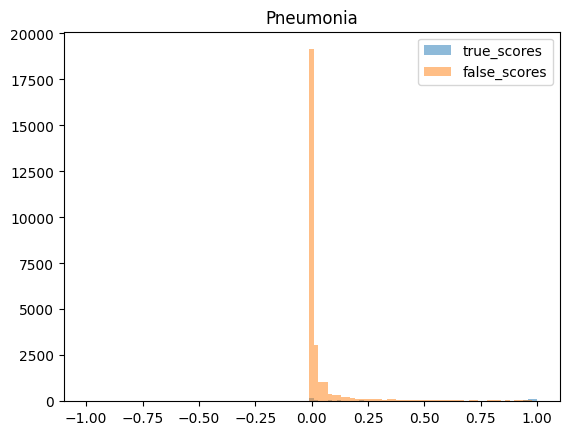

In [27]:
num_results = results_df.shape[0]
compare_hist(results_df["Pneumonia"], chex_df["Pneumonia"][:num_results], title="Pneumonia")

In [45]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [36]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [46]:
sum(p.numel() for p in model.parameters() if p.requires_grad), model.num_parameters()

AttributeError: 'SentenceTransformer' object has no attribute 'num_parameters'

In [41]:
from transformers import AutoTokenizer, AutoModel

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

sum(p.numel() for p in model.parameters() if p.requires_grad)

22713216

In [38]:
pipe = pipeline(
    model="facebook/bart-large-mnli",
    framework="pt",
    device=0,
)

In [42]:
model = AutoModel.from_pretrained('facebook/bart-large-mnli')

Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartModel: ['classification_head.out_proj.bias', 'classification_head.dense.weight', 'classification_head.out_proj.weight', 'classification_head.dense.bias']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AttributeError: 'ZeroShotClassificationPipeline' object has no attribute 'parameters'

In [43]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

406291456

In [44]:
model.num_parameters()

406291456